In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## IMPORT PACKAGES

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf

2025-07-21 10:16:59.575316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753093019.766040      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753093019.821564      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## LOAD DATA

In [31]:
def loaddata(major_path):
    diseases = []
    image_arr = []
    for disease_name in os.listdir(major_path):
        d_folder_path = os.path.join(major_path , disease_name)
        for disease_file in os.listdir(d_folder_path):
            disease_file_path = os.path.join(d_folder_path , disease_file)
            d_img = plt.imread(disease_file_path)
            if len(d_img.shape)  == 2:
                d_img = cv2.cvtColor(d_img , cv2.COLOR_GRAY2RGB)
            if d_img.shape[2] != 3:
                continue
            d_img = cv2.resize(d_img , (224,224))
            image_arr.append(d_img)
            diseases.append(disease_name)

    return diseases , image_arr

### load train data

In [32]:
train_labels , train_images = loaddata("/kaggle/input/brain-tumor-mri-dataset/Training")

In [33]:
print(len(train_labels) , len(train_images))

5708 5708


In [34]:
shapes = {x.shape for x in train_images if x.shape[2] != 3}
print(shapes)

set()


In [35]:
#convert image arrays to numpy
X = np.array(train_images)

In [37]:
y = np.array(train_labels)

### train test(val) split

In [38]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(X , y , 
                                                    train_size = 0.8 , shuffle= True,
                                                    random_state = 42) 

#check data size and structure
print(X_train.shape , X_val.shape ,y_train.shape , y_val.shape )

(4566, 224, 224, 3) (1142, 224, 224, 3) (4566,) (1142,)


### load test data

In [42]:
y_test , X_test = loaddata("/kaggle/input/brain-tumor-mri-dataset/Testing")
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape , y_test.shape)

(1311, 224, 224, 3) (1311,)


## ENCODE THE LABEL DATA

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

print(np.unique(y_train))

[0 1 2 3]


In [48]:
CLASSES = le.classes_
print(CLASSES)

['glioma' 'meningioma' 'notumor' 'pituitary']


## LOAD MOBILENET MODEL

In [49]:
IMAGE_SIZE = (224, 224)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # for speed and to prevent overfitting

I0000 00:00:1753096703.409290      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753096703.409941      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [56]:
num_of_classes = len(CLASSES)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape=(None, 224, 224, 3))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### fit model

In [57]:
BATCH_SIZE = 100
EPOCHS = 10

history = model.fit(
    X_train, y_train,
    validation_data=(X_val , y_val),
    epochs=EPOCHS,
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.7237 - loss: 0.7038 - val_accuracy: 0.8853 - val_loss: 0.3165
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8934 - loss: 0.3008 - val_accuracy: 0.8967 - val_loss: 0.2752
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9133 - loss: 0.2361 - val_accuracy: 0.9089 - val_loss: 0.2353
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9329 - loss: 0.1903 - val_accuracy: 0.9133 - val_loss: 0.2043
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9411 - loss: 0.1546 - val_accuracy: 0.9159 - val_loss: 0.2092
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9542 - loss: 0.1279 - val_accuracy: 0.9282 - val_loss: 0.1877
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9544 - loss: 0.1270 - val_accuracy: 0.9343 - val_loss: 0.1880
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9637 - loss: 0.1048 - val_acc

### Test With Test Data

In [58]:
y_test = le.transform(y_test)

In [67]:
predictions = []

In [ ]:
for test_img in X_test:
    pred = model.predict(np.expand_dims(test_img , axis = 0))
    y_pred = np.argmax(pred[0])
    predictions.append(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

### check Accuracy , f1 score , confusion matrix

In [81]:
from sklearn.metrics import accuracy_score , f1_score , confusion_matrix, ConfusionMatrixDisplay

In [77]:
Accuracy = accuracy_score(predictions , y_test)
f1 = f1_score(predictions , y_test , average="macro")

print(f"Accuracy : {Accuracy} , F1 score : {f1}")

Accuracy : 0.9359267734553776 , F1 score : 0.9310190711637092


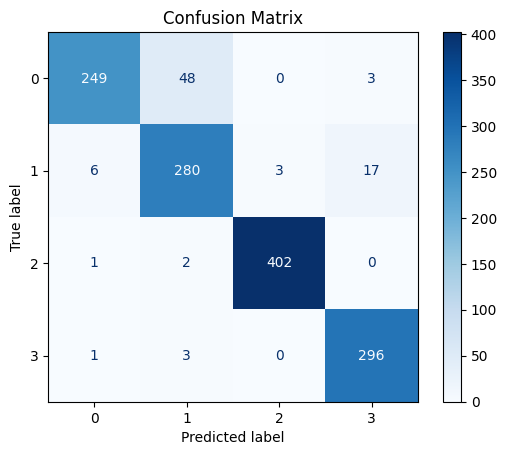

In [82]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## SAVE MODEL

In [83]:
#save classes
np.save("Tumor_classes.npy", CLASSES)

#save model
model.save("brain_tumor_model.h5")